# Multi-Agent Structures (1)

- Author: [Sunyoung Park (architectyou)](https://github.com/architectyou)
- Design:
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

An agent system is a system where LLMs can choose to control the flow of applications. As application systems become increasingly complex over time, managing and handling these systems during development has become more difficult. For example, you may encounter the following problems:

- Agents use too many `tools` to process, leading to poor quality decisions for subsequent `tool` calls.
- The context becomes too complex to track a single agent.
- Multiple specialized areas appear to be needed within the system (e.g., planner, researcher, math expert, etc.)

To deal with these situations, you can split your agent service into multiple agents.

Create independent agents and organize them into a **multi-agent** system.

These independent agents each have a single prompt and can make one LLM call or become complex agents like **ReAct Agent**.

The main benefits of using a multi-agent system are:

- **modularity**: easily separate, test, and maintain agents in the agentetic system.
- **specialization**: create domain-specific expert agents that improve the performance of the entire system.
- **control**: compared to **Function Calling**, you can clearly see how agents communicate.

There are 6 ways to configure multi-agents.

[이미지 삽입예정]

In this tutorial, we will explore the existing **single agent**, **network**, and **supervisor** structures among these.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Single Agent Review](#single-agent-review)
- [Hands-Off](#hands-off)
- [Network Structure](#network-structure)
- [Supervisor Structure](#supervisor-structure)

### References

- [LangGraph: Multi-agent Systems](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph: Multi-agent Network](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/)
- [LangGraph.Types: Command](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Command)
- [LangGraph: Multi-Agent Communication Between Agents](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#communication-between-agents)
---

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langgraph",
        "langchain-openai",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Multi-Agent Structures(1)",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

**[Note]** This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Single Agent Review

A Single Agent is an agent that has one `prompt` and makes one `LLM` call. It operates independently without interacting with other agents. However, as the service you want to build becomes more complex, it becomes difficult to handle complex tasks with just a single prompt and a single `LLM` call.

Therefore, while Single Agents are effective for performing specific tasks in clearly defined environments, they have the limitation of being more restricted compared to Multi-Agent systems in complex and dynamic environments.

Below is an example of a conversational chatbot structured using a single agent that provides simple responses.

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

Visualize the Graph.

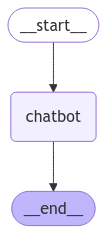

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Run the Single Agent based Chatbot Application.

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Creating a Multi-Agent System (MAS) using LangGraph involves several steps, as it combines principles of multi-agent systems with the capabilities of LangGraph, which is a framework for developing applications that utilize language models. Here’s a general approach to building a MAS with LangGraph:

### Step 1: Define the Agents

1. **Identify Agent Roles**: Determine the roles and responsibilities of each agent in your system. Each agent should have a specific purpose, such as information retrieval, decision-making, or communication.

2. **Design Agent Behaviors**: Define how each agent will behave and interact with other agents. This includes:
   - Communication protocols (how agents will share information)
   - Decision-making processes (how agents will make choices based on inputs)
   - Task allocation (how tasks will be divided among agents)

### Step 2: Set Up LangGraph

1. **Install LangGraph**: Ensure you have LangGraph installed in your development environment. You 

## Hands-Off

In a multi-agent architecture, agents can be represented as graph `nodes`. Each agent node executes a step and decides whether to complete execution or route to another agent. This potentially includes routing to itself (i.e., running in a loop). 

A common pattern in multi-agent interactions is a handoff, where one agent passes control to another agent. With handoffs, you can specify:

- **Destination**: The target agent to navigate to (e.g., the name of the `node` to move to)
- **Payload**: Information to pass to that agent (e.g., `state` updates)

To implement handoffs in LangGraph, agent nodes can return a `Command` object that combines control flow and state updates.

In [9]:
from typing import Literal
from langgraph.types import Command
def agent(state) -> Command[Literal["agent", "another_agent"]]:
    # the condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
    goto = get_next_agent(...)  # 'agent' / 'another_agent'
    return Command(
        # Specify which agent to call next
        goto=goto,
        # Update the graph state
        update={"my_state_key": "my_state_value"}
    )

In more complex scenarios where each agent `node` itself is a `graph` (i.e., a `subgraph`), a `node` in one of the agent subgraphs might want to move to another agent. For example, if you have two agents, `alice` and `bob` (`subgraph nodes` in the `parent graph`), and you need to move from `bob` to `alice`, you can set g`raph=Command.PARENT` in the `Command` object.

In [10]:
def some_node_inside_alice(state):
    return Command(
        goto="bob",
        update={"my_state_key": "my_state_value"},
        # specify which graph to navigate to (defaults to the current graph)
        graph=Command.PARENT,
    )

### Handoffs as Tools

One of the most common types of agents is the ReAct-style tool-calling agent. For this type of agent, a common pattern is to wrap handoffs as tool calls.

For example:

In [11]:
def transfer_to_bob(state):
    """Transfer to bob."""
    return Command(
        goto="bob",
        update={"my_state_key": "my_state_value"},
        graph=Command.PARENT,
    )

This is a special case of updating `graph state` from a `tool`, which includes control flow in addition to `state` updates.

## Network Structure

In this architecture, agents are defined as **graph nodes**. Each agent can communicate with all other agents (**many-to-many connections**) and can decide which agent to call next. This architecture is suitable for problems where there is no clear hierarchy of agents or specific order in which agents must be called.

In [12]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI(
    model="gpt-4o-mini",
)

def agent_1(state: MessagesState) -> Command[Literal["agent_2", "agent_3", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

def agent_2(state: MessagesState) -> Command[Literal["agent_1", "agent_3", END]]:
    response = model.invoke(...)
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

def agent_3(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    ...
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

builder = StateGraph(MessagesState)
builder.add_node(agent_1)
builder.add_node(agent_2)
builder.add_node(agent_3)

builder.add_edge(START, "agent_1")
network = builder.compile()

Visualize the Network.

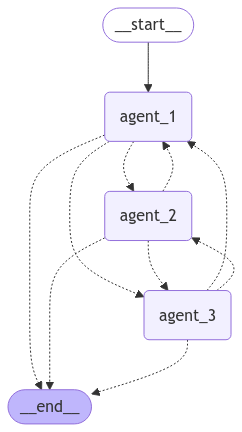

In [13]:
from IPython.display import Image, display

try:
    display(Image(network.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Supervisor Structure

In this architecture, we define agents as nodes and add a supervisor node (LLM) that decides which agent node to call next. We use Command to route execution to the appropriate agent node based on the supervisor's decision. This architecture is also suitable for running multiple agents in parallel or using map-reduce patterns.

In [14]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI(
    model="gpt-4o-mini",
)

def supervisor(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_agent"])

def agent_1(state: MessagesState) -> Command[Literal["supervisor"]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def agent_2(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(agent_1)
builder.add_node(agent_2)

builder.add_edge(START, "supervisor")

supervisor = builder.compile()

Visualize the Network.

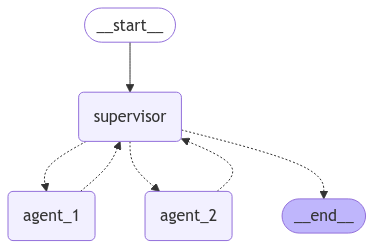

In [15]:
from IPython.display import Image, display

try:
    display(Image(supervisor.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass